In [ ]:
from functools import cache
from ast import literal_eval
import os
import re

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import quantile_transform
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

In [ ]:
evals = ['author', 'author_href', 'fandom', 'characters', 'genre', 'events', 'series',
       'warnings', 'beta', 'translator']
drops = [ 'fandom_href', 'characters_href', 'events_href', 'series_href',
       'beta_href', 'collections_href', 'translator_href']
fics = pd.read_csv('metadata_fics_clean.csv', converters={col: literal_eval for col in evals})
fics = fics.drop(columns=drops)
fics['summary'] = fics.summary.fillna('')
fics.head(1)

,id,error,name,type,summary,author,author_href,fandom,characters,rating,...,warnings,beta,translator,size_type,MB,n_words,k_simbols,n_pages,date_from,date_to
0,172221,False,Сны о путешествиях,джен,"Элли скучала, сидя за партой. Скучала, страдая...",[Almalgara Termallion],[/user283381],[Ориджиналы],[Новый Женский Персонаж],General,...,[],[],[],Мини,6,996,6,4,2022/01/27,2022/01/27


In [ ]:
pat = re.compile('(\d+)')
def proces_href(line, pat=pat):
    return pat.search(line).group()

In [ ]:
auth = pd.read_csv('authors.csv')
auth.head(1)

cts = pd.DataFrame()
cts['text_id'] = fics['id']
cts['auth_id'] = fics.author_href.apply(lambda x: [proces_href(el) for el in x])
cts['simb'] = fics['k_simbols']
cts = cts.explode('auth_id')
cts = cts.groupby('auth_id', as_index=False).agg({'text_id': 'count', 'simb': 'sum'})

auth['id'] = auth['id'].astype(str)
auth = auth.merge(cts, left_on='id', right_on='auth_id').drop(columns=['auth_id'])
auth = auth.reset_index(drop=True)

In [ ]:
def acad_conv(line):
    if 'высш' in line.lower():
        return 2
    elif 'средне' in line.lower():
        return 1
    else:
        return 0

In [ ]:
auth.text_id.describe()

count    5509.000000
mean        6.009439
std        16.092369
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       498.000000
Name: text_id, dtype: float64

In [ ]:
auth.simb.describe()

count     5509.000000
mean       499.068252
std       1191.842814
min          0.000000
25%         24.000000
50%        101.000000
75%        451.000000
max      35529.000000
Name: simb, dtype: float64

SignificanceResult(statistic=nan, pvalue=nan)


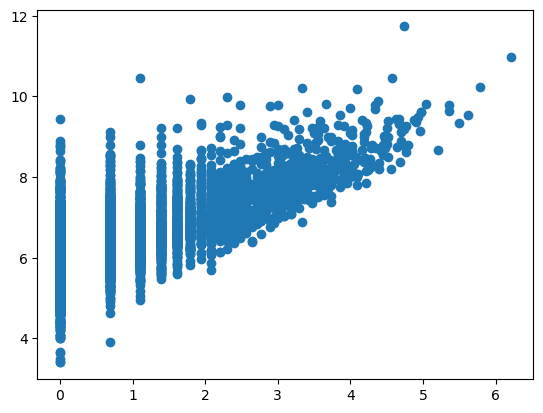

In [ ]:
print(stats.spearmanr(auth.text_id, auth['Рейтинг']))
plt.scatter(np.log(auth.text_id), np.log(auth['Рейтинг']));

SignificanceResult(statistic=nan, pvalue=nan)


/Users/v.i.zykova/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


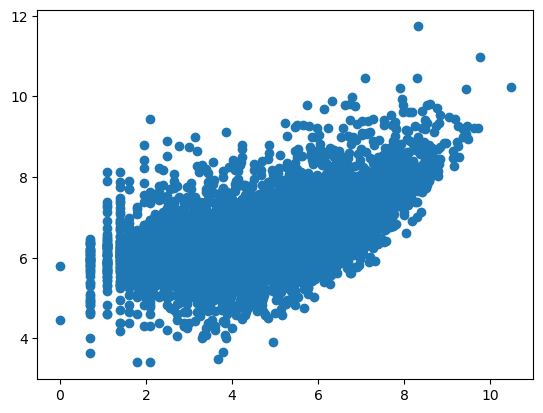

In [ ]:
print(stats.spearmanr(auth.simb, auth['Рейтинг']))
plt.scatter(np.log(auth.simb), np.log(auth['Рейтинг']));

SignificanceResult(statistic=0.5715265675440755, pvalue=0.0)


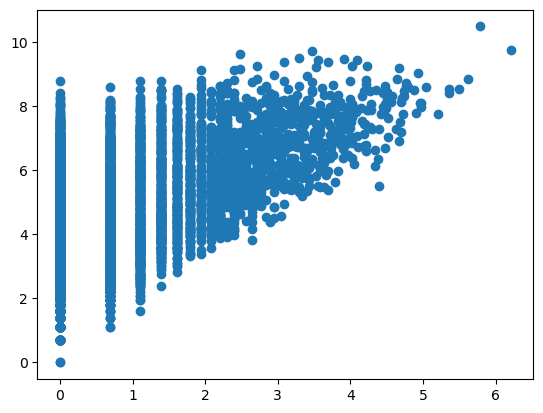

In [ ]:
print(stats.spearmanr(auth.text_id, auth.simb))
plt.scatter(np.log(auth.text_id), np.log(auth.simb));

In [ ]:
auth.loc[auth['Подписан'].isna() & -auth['Подписана'].isna(), 'Подписан'] = auth.loc[auth['Подписан'].isna() & -auth['Подписана'].isna(), 'Подписана']
auth['Подписан'] = auth['Подписан'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
auth['Личный сайт'] = (-auth['Личный сайт'].isna()).astype(int)

targets = []
text_cols = ['Любимые фильмы', 'Любимые книги', 'Начал читать', 'Начал писать', 'Первый фанфик',
       'Любимые персонажи', 'Любимые пейринги', 'Любимая категория',
       'Деятельность', 'Писать', 'Переводить', 'Рисовать',
        'Род деятельности', 'Любимые аниме', 'Любимая музыка', 'Любимые игры', 'Интересы',
     'Любимые комиксы', 'Любимые мюзиклы', 'Любимые аудиопостановки', 'Озвучивать']
skip = ['Email', 'Skype', 'Unnamed: 21', 'id', 'Дата рождения', 'Зарегистрирован', 'Звание',
 'Предыдущий ник', 'Реальное имя', 'Создавал', 'Создавала', 'Рейтинг', 'text_id', 'Привел друзей', 'simb']
categ = ['Образование', 'Откуда', 'Пол', 'Подписан']
flag = ['Личный сайт']

target = auth['simb']

auth[text_cols] = auth[text_cols].fillna('')
auth[categ] = auth[categ].fillna('')
auth[flag] = auth[flag].fillna(0)
auth[targets] = auth[targets].fillna(0)

auth['text'] = ''
for col in text_cols:
    auth['text'] += ' ' + auth[col]

gender = auth['Пол'].apply(lambda x: int(x == 'женский')).to_numpy()
acad = auth['Образование'].apply(acad_conv).to_numpy()
site = auth['Личный сайт'].to_numpy()

enc = OneHotEncoder(handle_unknown='ignore')
origin = enc.fit_transform(auth[['Откуда']]).toarray()

enc_sub = CountVectorizer()
subscr = enc_sub.fit_transform(auth['Подписан'].apply(lambda x: ' '.join([el.replace(' ', '#') for el in x]))).toarray()

vectorizer = TfidfVectorizer(lowercase=True, max_features=1000)
text = vectorizer.fit_transform(auth['text']).toarray()

In [ ]:
features = np.hstack([np.array(['gender', 'learning', 'site', ]), enc.get_feature_names_out(),
                      enc_sub.get_feature_names_out(), vectorizer.get_feature_names_out()])

In [ ]:
data = np.hstack([gender.reshape(-1, 1), acad.reshape(-1, 1), site.reshape(-1, 1), origin, subscr, text])
target = target.to_numpy()
y_trans = quantile_transform(target.reshape(-1, 1), n_quantiles=900, output_distribution="normal", copy=True).squeeze()

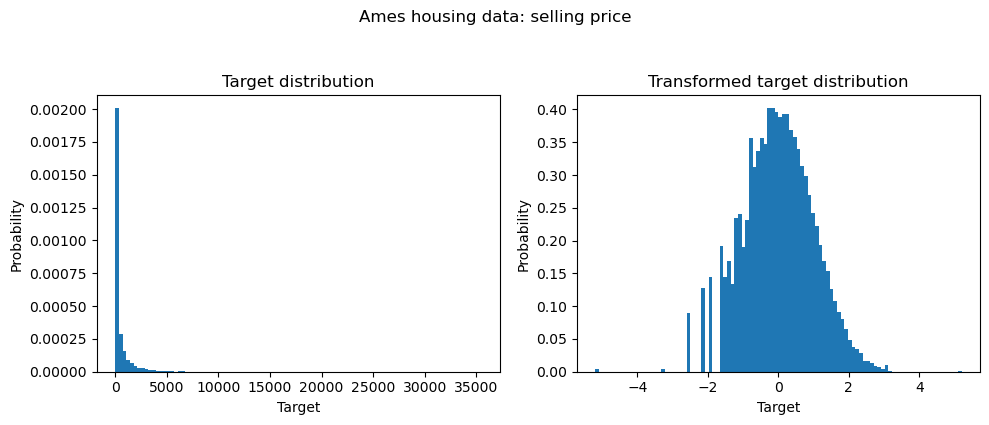

In [ ]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ax0.hist(target, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("Ames housing data: selling price", y=1.05)
plt.tight_layout()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, y_trans, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
gbr = GradientBoostingRegressor(random_state=0)
scores = cross_val_score(gbr, data, y_trans, cv=5, verbose=5)
scores

[CV] END ................................ score: (test=0.049) total time=  47.5s
[CV] END ................................ score: (test=0.022) total time=  46.5s
[CV] END ................................ score: (test=0.037) total time=  47.5s
[CV] END ................................ score: (test=0.038) total time=  47.4s
[CV] END ................................ score: (test=0.044) total time=  47.1s


array([0.04851947, 0.0218657 , 0.03674929, 0.03804044, 0.04449962])

In [ ]:
def evaluate(esti, x, xev, y, yev):
    esti.fit(x, y)

    pred_train = esti.predict(x)
    pred_test = esti.predict(xev)

    metrics = {'MSE': mean_squared_error, 'R2': r2_score, 'EVS': explained_variance_score}
    res = {'train': {}, 'test': {}}
    for mname, metric in metrics.items():
        res['train'][mname] = metric(y, pred_train)
        res['test'][mname] = metric(yev, pred_test)
    return res

In [ ]:
gbr = GradientBoostingRegressor(random_state=0)
evaluate(gbr, x_train, x_test, y_train, y_test)

{'train': {'MSE': 0.7860177601681061,
  'R2': 0.20888375233934176,
  'EVS': 0.20888375233934176},
 'test': {'MSE': 1.0040268182724565,
  'R2': 0.034305100864209126,
  'EVS': 0.04437302578832181}}

In [ ]:
linreg = LinearRegression()
evaluate(linreg, x_train, x_test, y_train, y_test)

{'train': {'MSE': 0.3241876059813377,
  'R2': 0.6737095580038848,
  'EVS': 0.6737100487092287},
 'test': {'MSE': 2.6296503166130855e+24,
  'R2': -2.529255046825813e+24,
  'EVS': -2.5287481431027837e+24}}

In [ ]:
knn = KNeighborsRegressor()
evaluate(knn, x_train, x_test, y_train, y_test)

{'train': {'MSE': 0.8464555577011478,
  'R2': 0.14805392631735892,
  'EVS': 0.16849157887935928},
 'test': {'MSE': 1.2592382552791659,
  'R2': -0.21116282731578795,
  'EVS': -0.1350164135462526}}

In [ ]:
rfr = RandomForestRegressor()
evaluate(rfr, x_train, x_test, y_train, y_test)

{'train': {'MSE': 0.33237208166483506,
  'R2': 0.665471993892848,
  'EVS': 0.6654742243449406},
 'test': {'MSE': 1.0178178735031351,
  'R2': 0.021040563057458717,
  'EVS': 0.03138325190868951}}

In [ ]:
gbr.feature_importances_.argsort()[:-10:-1]

array([   1, 5817, 5086, 5059,  705, 5282, 5225, 3283, 5569])

In [ ]:
features[gbr.feature_importances_.argsort()[:-10:-1]]

array(['learning', 'слэш', 'автор', 'https', 'Откуда_Слоним', 'джен',
       'гет', 'лавкрафта', 'назад'], dtype=object)